<a href="https://colab.research.google.com/drive/1WrXSTgCwXfc7oIuYTxn8rJK0oLNFipxG?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Нейросетевая классификация текстов


In [1]:
from IPython.display import clear_output
!pip install datasets
clear_output()

### импорт необходимых библиотек

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import pandas as pd
import random
import os

import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
sns.set(palette='summer')
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import re
import time
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Данные (загрузка)

[Russian Social Media Text Classification](https://www.kaggle.com/datasets/mikhailma/russian-social-media-text-classification/data)


Датасет содержит тексты из спортивных сообществ социальной сети ВКонтакте.
Содержит 13 подкатегорий тем.

In [27]:
!wget https://github.com/lteplova/rnn_in_nlp/raw/0a8c6345a1250af3ef5439fbb054c7092c5e88cd/data/dataset_media.zip

--2024-05-23 11:26:51--  https://github.com/lteplova/rnn_in_nlp/raw/0a8c6345a1250af3ef5439fbb054c7092c5e88cd/data/dataset_media.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lteplova/rnn_in_nlp/0a8c6345a1250af3ef5439fbb054c7092c5e88cd/data/dataset_media.zip [following]
--2024-05-23 11:26:52--  https://raw.githubusercontent.com/lteplova/rnn_in_nlp/0a8c6345a1250af3ef5439fbb054c7092c5e88cd/data/dataset_media.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15816253 (15M) [application/zip]
Saving to: ‘dataset_media.zip’

dataset_media.zip   100%[===================>]  15.08M  --.-KB/s    in

In [28]:
!unzip dataset_media.zip

Archive:  dataset_media.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [60]:
#loading the data
reviews = pd.read_csv("train.csv")
print(reviews.shape)
reviews.head()

(38740, 3)


,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...


In [61]:
set(reviews.category), len(set(reviews.category))

({'athletics',
  'autosport',
  'basketball',
  'boardgames',
  'esport',
  'extreme',
  'football',
  'hockey',
  'martial_arts',
  'motosport',
  'tennis',
  'volleyball',
  'winter_sport'},
 13)

In [62]:
reviews.text[1]

'Возвращение в подземелье Треша 33 Эйфория тупости и жадности зашкаливает 33 В этот раз мы посетим Ростовскую область. Всю. И знаете это пока что единственный выпуск в котором не будет. . . А впрочем сами все увидите 33 Ссылка на видео в источнике'

In [63]:
reviews[reviews.duplicated()] # вывод дубликатов

,oid,category,text
1482,842513089,basketball,Питание – один из самых важных процессов в наш...
1601,31593254,boardgames,Приветствуем коллеги 33 А во что вы играли на ...
2110,845723373,martial_arts,Это первое интервью Мокаева в Дагестане Молодо...
2130,240880977,martial_arts,Вам не нужно теперь ломать голову что подарить...
3561,885529499,martial_arts,Расписание на вторник КРАСНАЯ ПРЕСНЯ 19. 00 ММ...
...,...,...,...
38566,217746176,esport,Будет 2 победителя Принять участие Включить ув...
38607,774280988,hockey,Смотрите матч Спартак – Зенит на Кинопоиске. Д...
38651,550304346,basketball,За кроссовками в Баскетбольный магазин Ghetto ...
38668,229536361,basketball,За жилетами в Баскетбольный магазин Ghetto Bas...


In [64]:
# удаление дубликатов
reviews = reviews.drop_duplicates(keep=False)
reviews

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...
...,...,...,...
38735,910636962,autosport,8 битная буря снова накрыла пикселями автомоби...
38736,669736851,autosport,Ира Сидоркова объясняет как сказалась на ее ма...
38737,558919241,tennis,24 я ракетка мира хорват Марин Чилич обыграл и...
38738,776944963,volleyball,Стал известен календарь мужской сборной России...


In [65]:
# проверим распределение классов и сбалансированность датасета
# функция создает датасет с распределением классов
def loads_labels(dataset):
    labels = []
    for i in dataset:
        labels.append(i)
    counts = Counter(labels)
    count_df =  pd.DataFrame([(k, v) for k, v in counts.items()],
    columns=['category', 'count'])
    return count_df.sort_values(by = 'count', ascending = False)

In [66]:
df_balance = loads_labels(reviews.category.values)
df_balance.reset_index()

,index,category,count
0,10,autosport,3116
1,1,extreme,3020
2,7,motosport,3014
3,9,tennis,2996
4,11,martial_arts,2974
5,6,athletics,2947
6,4,hockey,2932
7,3,boardgames,2929
8,12,volleyball,2920
9,5,esport,2877


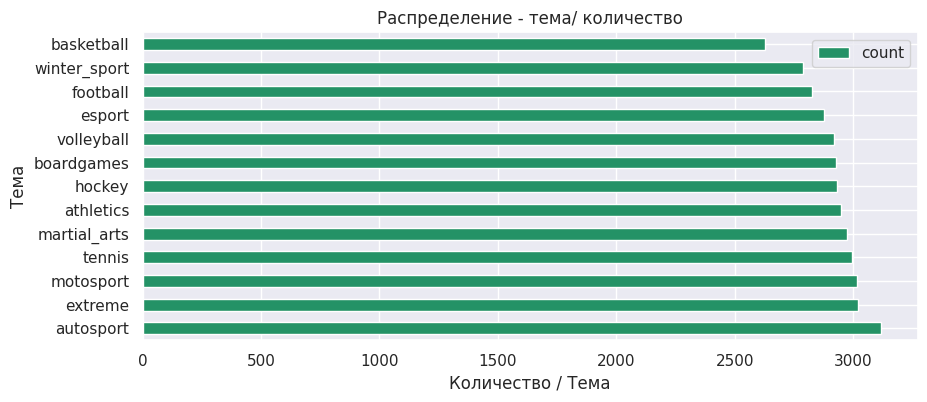

In [67]:
ax = df_balance.plot.barh(x='category', y='count', rot=0, figsize = (10,4), title='Распределение - тема/ количество',
                     xlabel='Количество / Тема',
                     ylabel='Тема')

Данные нормально сбалансированы по классам, можем использовать accuracy как метрику

In [68]:
# кодировка таргета
le = LabelEncoder()
le.fit(reviews['category'])
reviews['label'] =  le.transform(reviews['category'])
reviews

,oid,category,text,label
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...,12
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...,5
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...,6
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...,3
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...,7
...,...,...,...,...
38735,910636962,autosport,8 битная буря снова накрыла пикселями автомоби...,1
38736,669736851,autosport,Ира Сидоркова объясняет как сказалась на ее ма...,1
38737,558919241,tennis,24 я ракетка мира хорват Марин Чилич обыграл и...,10
38738,776944963,volleyball,Стал известен календарь мужской сборной России...,11


In [69]:
le.classes_

array(['athletics', 'autosport', 'basketball', 'boardgames', 'esport',
       'extreme', 'football', 'hockey', 'martial_arts', 'motosport',
       'tennis', 'volleyball', 'winter_sport'], dtype=object)

In [40]:
from joblib import dump
dump(le, 'le.joblib', compress=9)

['le.joblib']

In [70]:
# вычисление длин текстов
reviews['review_length'] = reviews['text'].apply(lambda x: len(x.split())) # length of post (words)
reviews

,oid,category,text,label,review_length
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...,12,6
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...,5,43
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...,6,110
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...,3,209
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...,7,382
...,...,...,...,...,...
38735,910636962,autosport,8 битная буря снова накрыла пикселями автомоби...,1,61
38736,669736851,autosport,Ира Сидоркова объясняет как сказалась на ее ма...,1,96
38737,558919241,tennis,24 я ракетка мира хорват Марин Чилич обыграл и...,10,43
38738,776944963,volleyball,Стал известен календарь мужской сборной России...,11,143


In [42]:
reviews.describe().T

,count,mean,std,min,25%,50%,75%,max
oid,37968.0,5.022693e+08,2.829830e+08,16594.0,266756352.0,506829589.0,741931849.0,999711263.0
label,37968.0,5.997340e+00,3.736898e+00,0.0,3.0,6.0,9.0,12.0
review_length,37968.0,6.136623e+01,7.188862e+01,3.0,16.0,35.0,75.0,634.0


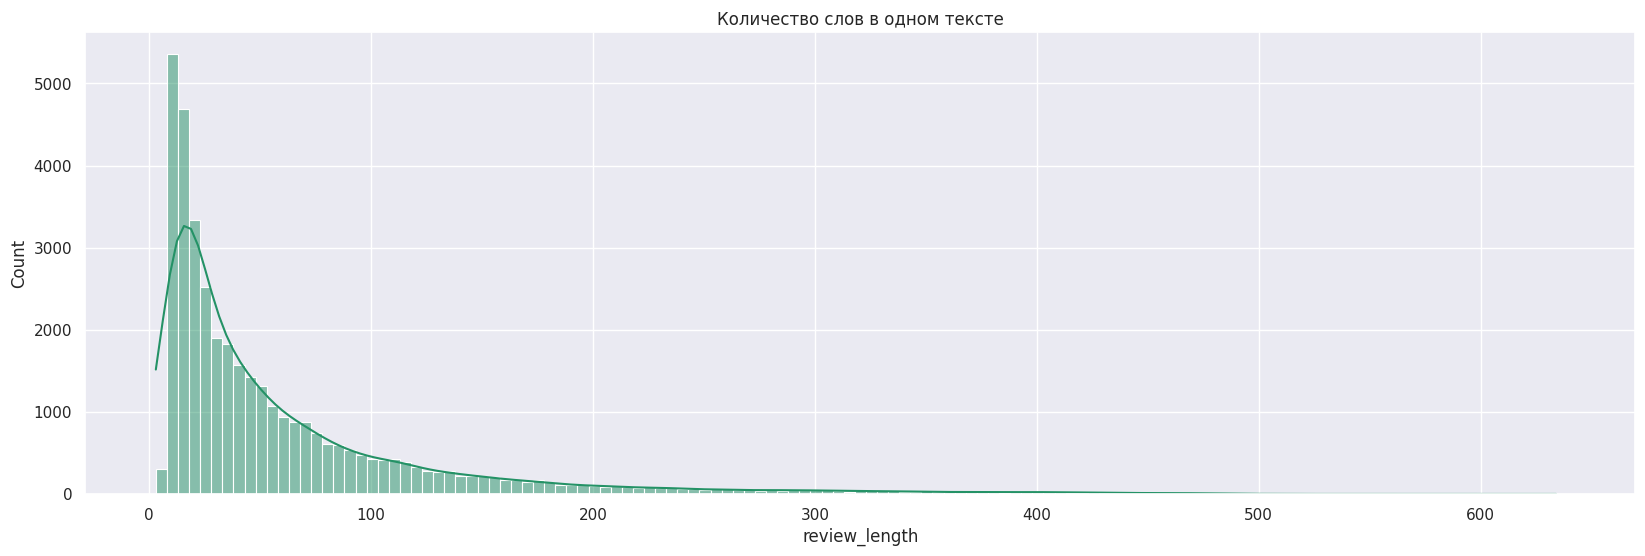

In [ ]:
plt.figure(figsize = (20, 6))
sns.histplot(reviews["review_length"], kde=True, binwidth=5).set_title("Количество слов в одном тексте");

In [71]:
# подготовка датасета, сохранение нужных колонок
df = pd.DataFrame()
df = reviews[['text', 'label']]
df['ind'] = df.index
df

,text,label,ind
0,Волшебные фото Виктория Поплавская ЕвгенияМедв...,12,0
1,Возвращение в подземелье Треша 33 Эйфория тупо...,5,1
2,Лучшие чешские вратари – Доминик Доминатор Гаш...,6,2
3,Rtokenoid Warhammer40k валрак решил нас подкор...,3,3
4,Шестеркин затаскивает Рейнджерс в финал Восточ...,7,4
...,...,...,...
38735,8 битная буря снова накрыла пикселями автомоби...,1,38735
38736,Ира Сидоркова объясняет как сказалась на ее ма...,1,38736
38737,24 я ракетка мира хорват Марин Чилич обыграл и...,10,38737
38738,Стал известен календарь мужской сборной России...,11,38738


In [72]:
df.to_csv('trainn.csv', index=False)

In [73]:
# Создадим датасет, с которым будем работать дальше, для передачи в модель
dataset = load_dataset('csv', data_files='trainn.csv')
dataset = dataset.filter(lambda example: example['text'] is not None and example['label'] is not None)

dataset

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/37968 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'ind'],
        num_rows: 37968
    })
})

In [74]:
# разделим на обучающую и тестовую
dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'ind'],
        num_rows: 30374
    })
    test: Dataset({
        features: ['text', 'label', 'ind'],
        num_rows: 7594
    })
})

In [75]:
# вывод одного примера
dataset['train'][0]

{'text': 'Королева переобуваний перебежчицу Трусову публично подвергли порицанию. Влюбленная спортсменка снова забыла кто стоял за ее успехом. Пока русская ракета Саша Трусова оттачивает знаменитые четверные коллеги по льду строят спортсменке козни.',
 'label': 12,
 'ind': 16272}

In [76]:
dataset['train'][1]

{'text': 'news LampPost next week А в этой части у нас фигурки от макфарлайн которые приезжают в вебстор гв Картина сестер битвы Ну и вархаммер тв с стримами',
 'label': 3,
 'ind': 26037}

### Токенизация

In [77]:
# токенизация текстов (разбиение текстов на токены (слова) с помощью word_tokenize)
words = Counter()
for example in tqdm(dataset['train']['text']):
  processed_text = example.lower()
  for word in word_tokenize(processed_text):
    words[word] += 1

  0%|          | 0/30374 [00:00<?, ?it/s]

In [78]:
len(words)

133375

In [79]:
tags = ['<unk>', '<bos>','<eos>', '<pad>'] # служебные токены, для обозначение начала, конца текста и отсутствующих слов в словаре
vocab = set(tags)
counter_threshold = 5

# формирование словаря c учетом counter_threshold
for char, count in words.items():
  if count > counter_threshold:
    vocab.add(char)

len(vocab)

28633

In [82]:
# кодирование в словарь (слово-индекс) и обратно (индекс-слово)
word2idx = {char:i for i, char in enumerate(vocab)}
idx2word = {i:char for char, i in word2idx.items()}

In [81]:
import pickle
with open('word2idx.pkl', 'wb') as f:
    pickle.dump(word2idx, f)

In [83]:
dataset['train']

Dataset({
    features: ['text', 'label', 'ind'],
    num_rows: 30374
})

In [84]:
# Создание  pytorch датасета
class WordDataset:
  def __init__(self, sent):
    self.data = sent
    self.unk_id, self.bos_id, self.eos_id, self.pad_id  = [word2idx[tag] for tag in tags]

  def __getitem__(self, idx: int) -> dict:
    processed_txt = self.data[idx]['text'].lower().translate(str.maketrans('', '', string.punctuation)) # препроцессинг
    tok_sent = [self.bos_id]
    tok_sent += [word2idx.get(word, self.unk_id) for word in word_tokenize(processed_txt)] # кодирование по словарю
    tok_sent += [self.eos_id]

    train_sample = {
        'text': tok_sent,
        'label': self.data[idx]['label'],
        'ind': self.data[idx]['ind']
    }
    return train_sample


  def __len__(self) -> int:
    return len(self.data)

# упаковка в тензоры одинаковой длины
def collate_fn_with_padding(input_batch: List[List[int]], pad_id=word2idx["<pad>"], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for seq in input_batch:
        seq['text'] = seq['text'][:max_seq_len]
        for _ in range(max_seq_len - len(seq['text'])):
            seq['text'].append(pad_id)

        new_batch.append(seq['text'])

    seqs = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)
    idx_ = torch.LongTensor([x['ind'] for x in input_batch]).to(device)

    return {'input_idx': seqs, 'label': labels, 'idx': idx_}

In [85]:
# фиксация стэйта
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch(42)

In [86]:
train_dataset = WordDataset(dataset['train'])
eval_dataset = WordDataset(dataset['test'])
batch_size = 64

# формирование dataloader
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [87]:
next(iter(train_dataloader))

{'input_idx': tensor([[ 9404, 14949, 22748,  ..., 12284, 12284, 12284],
         [ 9404, 18206, 26749,  ..., 12284, 12284, 12284],
         [ 9404, 14609, 25860,  ..., 12284, 12284, 12284],
         ...,
         [ 9404, 21203, 17035,  ..., 12284, 12284, 12284],
         [ 9404, 22748, 22748,  ..., 12284, 12284, 12284],
         [ 9404, 19170,  8939,  ..., 12284, 12284, 12284]], device='cuda:0'),
 'label': tensor([ 2,  5, 10,  8,  7, 11,  4,  8,  1, 10,  1,  2,  0,  9, 12,  5,  6,  6,
         11,  4,  4,  0, 12,  8,  4,  9,  0,  6,  8,  4,  0, 11,  1,  6,  2, 10,
          2,  8,  4,  4,  0,  8,  8,  5,  2,  4, 12,  7,  6,  4,  6,  4, 10,  0,
          9,  0,  2,  7,  7,  2,  1, 10,  0,  4], device='cuda:0'),
 'idx': tensor([21053, 37122, 24220, 35149, 32345, 34648, 13562, 30901, 18748, 20381,
         38510, 22596,  5502,  7429, 27019,  7441, 13904, 12005, 36246, 11444,
          3057, 35214, 36084, 26008,  3290, 31939, 35586,   185, 13771, 19398,
         14382, 32172,   281, 20077,

In [88]:
for el in train_dataloader:
    print(el['input_idx'].shape)
    break

torch.Size([64, 256])


## Обучение модели

#### Функции обучение/отрисовка результата

In [89]:
# функция для валидации
def evaluate(model, eval_dataloader) -> float:
    """
    Вычисление accuracy на валидационной выборке
    """

    predictions = []
    target = []
    loss_ = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_idx'])
            loss = criterion(logits, batch['label'])
            loss_.append(loss.item())
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()
    loss_eval = sum(loss_) / len(loss_)

    return accuracy, loss_eval

In [90]:
# Функция запуска обучения
def train_loop_max(epoch):
    num_epoch = epoch
    eval_steps = len(train_dataloader) // 2

    history = defaultdict(lambda: defaultdict(list))
    loss_train, loss_eval, acc, = [], [], []
    best_loss = None
    best_model = None
#     best_val_acc = 0.0

    for epoch in range(num_epoch):
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch+1}:')):

            logits = model(batch['input_idx'])
            loss = criterion(logits, batch['label'])
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if i % eval_steps == 0:
                model.eval()
                accuracy, loss_ev = evaluate(model, eval_dataloader)
                loss_eval.append(loss_ev)
                acc.append(accuracy)
                model.train()


        lr_value = optimizer.state_dict()['param_groups'][0]['lr']
        history['lr']['step'].append(lr_value)
        scheduler.step()

        loss_tr = sum(loss_train) / len(loss_train)
        loss_ev = sum(loss_eval) / len(loss_eval)

        print('train_loss', loss_tr)
        print('val_loss', loss_ev)
        print(f'val_accuracy {accuracy*100:.2f}')
        print('learning rate', lr_value)



        history['loss_t']['train'].append(loss_tr)
        history['loss_e']['train'].append(loss_ev)
        history['acc']['eval'].append(accuracy)

        # if accuracy > best_val_acc:  # проверка метрики и сохранение лучшей модели на основании лучшей метрики
        #     best_val_acc = accuracy
        #     best_model = model.state_dict()

        if best_loss is None:
            best_loss = loss_ev
        if loss_ev <  best_loss:
            best_loss = loss_ev
            best_model = model.state_dict()
            torch.save(best_model, f'best_m{epoch+1}.pt')
            print(f'На {epoch+1} эпохе была сохранена модель со значением функции потерь на валидации {loss_ev:.4f}', end='\n\n')

    return best_model, history

In [22]:
def plot_learning(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    plt.figure(figsize=(20, 5))

    plt.subplot(1,3,1)
    plt.title('Loss', fontsize=10)
    plt.plot(history['loss_t']['train'], color='red', label='train')
    plt.plot(history['loss_e']['train'], color='blue', label='val')
    plt.ylabel('лосс', fontsize=10)
    plt.xlabel('эпоха', fontsize=10)
    plt.legend(fontsize=10)

    plt.subplot(1,3,2)
    plt.title('Accuracy', fontsize=8)
    plt.plot(history['acc']['eval'], label='validation')
    plt.ylabel('лосс', fontsize=10)
    plt.xlabel('эпоха', fontsize=10)
    plt.legend(fontsize=10)

    plt.subplot(1,3,3)
    plt.title("learning vs. epoch", fontsize=8)
    plt.plot(history['lr']['step'], color='orange', label='steps')
    plt.xlabel("эпоха", fontsize=8)
    plt.ylabel("learning rate", fontsize=8)
    plt.legend(fontsize=5)
    plt.show()

    print(f"Лучшая accuracy : {(max(history['acc']['eval']) * 100):.2f}")

#### Архитектура сети

Рекурентный слой LSTM, Bidirectional = True, используем максимум из слоя Embedding и конкатенируем с эмбедингом последнего слоя, функция активации nn.Tanh()

In [91]:
class RNN_Classiff_max(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int, num_layers: int,
        aggregation_type: str = 'max'
        ):

        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, bidirectional = True, dropout = 0.2, batch_first=True)
        self.linear = nn.Linear(hidden_dim * 4, hidden_dim)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.3)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:

            embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
            output, h = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
            output_max = output.max(dim=1)[0] #[batch_size, hidden_dim] (берем агрегацию по максимуму)
            last_hidden_state = output[:, -1, :] # эмбеддинг с последнего токена
            output = torch.cat((last_hidden_state, output_max), dim=1) #  конкатенация результата агрегации и эмбеддинга с последнего токена

            concat_output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
            concat_output = self.batchnorm(concat_output)
            prediction = self.projection(self.non_lin(concat_output))  # [batch_size, num_classes]

            return prediction

#### Запуск обучения

In [92]:
model = RNN_Classiff_max(hidden_dim=512, vocab_size=len(vocab), num_classes = len(set(df.label)), num_layers = 2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 6, 8], gamma=0.7)

In [93]:
mod, history = train_loop_max(epoch = 10)

Training epoch 1::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 1.3923148672204269
val_loss 1.4934447627274599
val_accuracy 75.47
learning rate 0.001


Training epoch 2::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.9837826188300786
val_loss 1.1208896851923622
val_accuracy 80.06
learning rate 0.001
На 2 эпохе была сохранена модель со значением функции потерь на валидации 1.1209



Training epoch 3::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.7531242195190044
val_loss 0.9883518839806293
val_accuracy 81.10
learning rate 0.001
На 3 эпохе была сохранена модель со значением функции потерь на валидации 0.9884



Training epoch 4::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.6003190409852878
val_loss 0.9415192729597833
val_accuracy 81.79
learning rate 0.001
На 4 эпохе была сохранена модель со значением функции потерь на валидации 0.9415



Training epoch 5::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.49410131812821095
val_loss 0.9228167500899953
val_accuracy 82.08
learning rate 0.0007
На 5 эпохе была сохранена модель со значением функции потерь на валидации 0.9228



Training epoch 6::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.41926341980385284
val_loss 0.9168051430045945
val_accuracy 81.88
learning rate 0.0007
На 6 эпохе была сохранена модель со значением функции потерь на валидации 0.9168



Training epoch 7::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.36423451274307794
val_loss 0.9160711495410732
val_accuracy 82.13
learning rate 0.00049
На 7 эпохе была сохранена модель со значением функции потерь на валидации 0.9161



Training epoch 8::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.32263264493946303
val_loss 0.9180287211736876
val_accuracy 81.78
learning rate 0.00049


Training epoch 9::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.29016704464971216
val_loss 0.9229109108614987
val_accuracy 81.70
learning rate 0.000343


Training epoch 10::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.26391222451633384
val_loss 0.9320719218262437
val_accuracy 81.33
learning rate 0.000343


In [ ]:
# загрузка лучшей сохраненной модели
new_model = RNN_Classiff_max(hidden_dim=512, vocab_size=len(vocab), num_classes = 13, num_layers = 2).to(device)
load_model_state = torch.load('/kaggle/working/best_m7.pt', map_location = device)
new_model.load_state_dict(load_model_state)

<All keys matched successfully>

#### Отображение результата

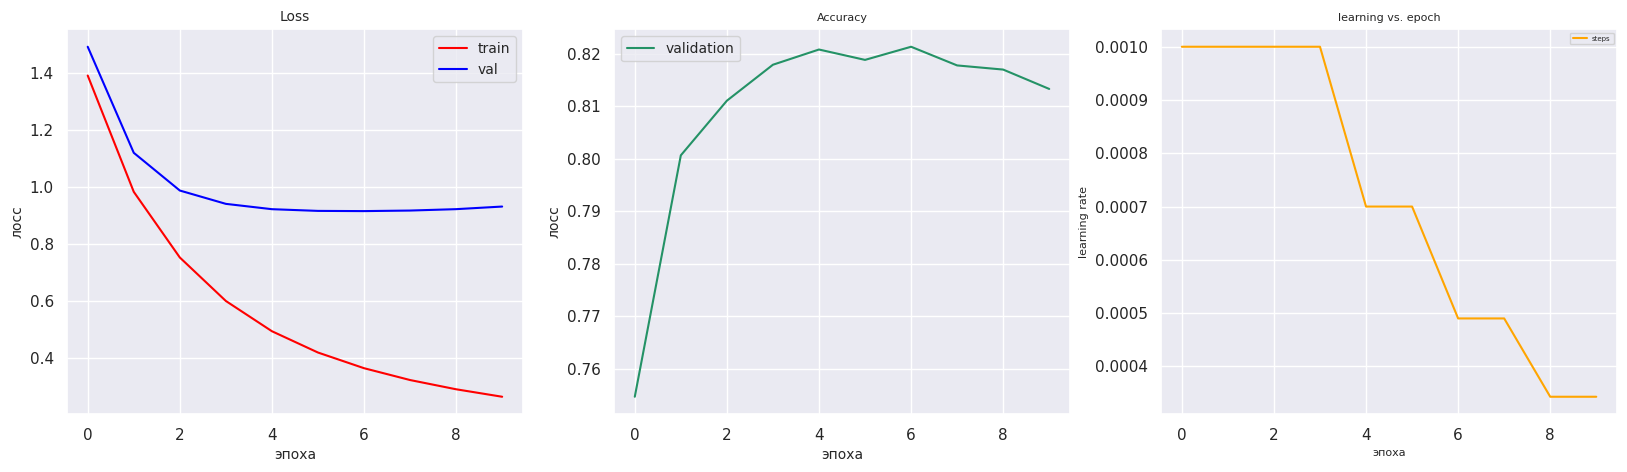

Лучшая accuracy : 82.13


In [94]:
plot_learning(history)

Вывод по графикам:

1. По графику функции потерь наблюдаем уменьшение ошибки, что хорошо, модель обучается успешно, на валидационной выборке падение ошибки прекращается после 7-й эпохи.
2. Точность в процессе обучения растет, модель обучается.
3. learning_rate в размере 0.0005 - 0.0007 показывает наилушую метрику

Можно пытаться подбирать гиперпараметры (поменять размер скрытого слоя, количество скрытых слоев)

### Анализ ошибок модели

Функция применения модели для валидационной части датасета

In [95]:
def evaluate_test(model, eval_dataloader) -> float:
    """
    Вычисление accuracy на валидационной выборке
    """

    predictions = []
    target = []
    loss_ = []
    index = []
    model.eval()
    model.to(device)
    with torch.no_grad():
        for batch in eval_dataloader:
            index.append(batch['idx'])
            logits = model(batch['input_idx'])
            loss = criterion(logits, batch['label'])
            loss_.append(loss.item())
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    index = torch.cat(index)

    accuracy = (predictions == target).float().mean().item()
    loss_eval = sum(loss_) / len(loss_)

    return predictions, target, index

In [108]:
new_model = RNN_Classiff_max(hidden_dim=512, vocab_size=len(vocab), num_classes = 13, num_layers = 2).to(device)
load_model_state = torch.load('best_m7.pt', map_location = device)

new_model.load_state_dict(load_model_state)

<All keys matched successfully>

In [109]:
predictions, target, index =  evaluate_test(new_model, eval_dataloader)

In [111]:
idx, pred, label = [], [], []
pred = [el.item() for el in predictions]
idx = [el.item() for el in index]
label = [el.item() for el in target]
compare_df = pd.DataFrame(columns = ['ind', 'prediction', 'target'])
compare_df = pd.DataFrame({'ind' : idx, 'prediction' : pred, 'target' : label})

In [112]:
# Датасет с ошибочными предсказаниями
error = compare_df.loc[((compare_df['prediction'] != compare_df['target']))]
error['category_true'] = le.inverse_transform(error['target'].values)
error['category_pred'] = le.inverse_transform(error['prediction'].values)

new  = pd.merge(error, df, on="ind", how="inner")
new

,ind,prediction,target,category_true,category_pred,text,label
0,1998,6,1,autosport,football,‼️Внимание открылась новая шиномонтажная масте...,1
1,33348,0,2,basketball,athletics,️Доброго времени суток здесь ты можешь увидеть...,2
2,24190,6,4,esport,football,Успейте оформить кредитную карту от Альфа Банк...,4
3,23508,6,10,tennis,football,Еще один насыщенный день на эмоции сегодня нас...,10
4,28280,11,2,basketball,volleyball,В телеграмме так же есть активность в будущем ...,2
...,...,...,...,...,...,...,...
1352,26592,4,11,volleyball,esport,Добрый вечер 33 Спортивный пляж Казани проводи...,11
1353,203,5,11,volleyball,extreme,Серия кресел Legend от бренда KARNOX – это лег...,11
1354,12066,9,1,autosport,motosport,Кими Райкконен завершивший выступления в Форму...,1
1355,16245,0,12,winter_sport,athletics,Мы уже ждем вас на Северном склоне курорта Бол...,12


Посмотрим в каких категориях больше всего ошибок

In [113]:
df_new = loads_labels(new.category_true.values)
df_new.reset_index()

,index,category,count
0,7,football,175
1,6,martial_arts,162
2,5,extreme,148
3,2,esport,120
4,1,basketball,111
5,10,hockey,106
6,11,volleyball,99
7,0,autosport,96
8,4,athletics,91
9,9,winter_sport,85


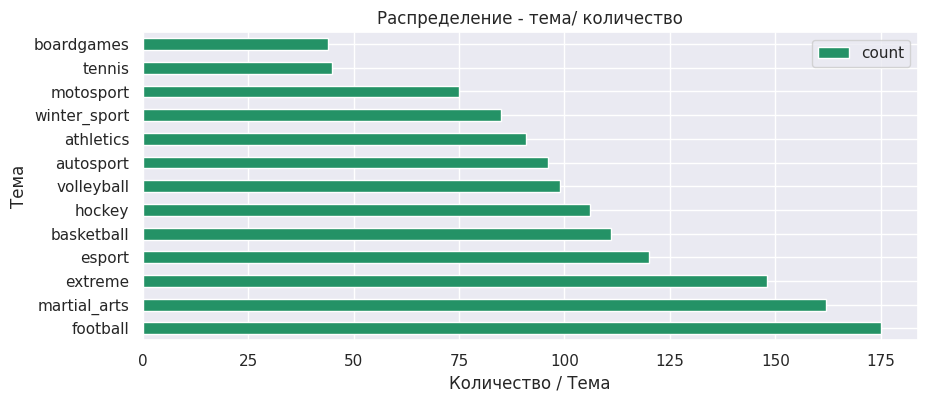

In [114]:
ax = df_new.plot.barh(x='category', y='count', figsize = (10,4), title='Распределение - тема/ количество',
                     xlabel='Количество / Тема',
                     ylabel='Тема')

Попробуем применить Лемматизацию к тексту и сравнить результат.
Есть подозрение, что модель плохо выучила формы слов, возможно они не попали в словарь.

### Применение Лемматизации и сравнение результатов

In [4]:
# используем библиотеку pymorphy так как она поддерживает русский язык
!pip install pymorphy3

clear_output()

In [6]:
import pymorphy3
morph = pymorphy3.MorphAnalyzer()

from tqdm.auto import tqdm
tqdm.pandas()

# функция приводит слова в нормальную форму
def lemmatize(text):
    try:
        return  " ".join([morph.parse(w)[0].normal_form for w in text.lower().split()])
    except:
        return " "

reviews.text = reviews.text.astype('str').progress_apply(lemmatize)
reviews

In [43]:
# подготовка датасета, сохранение нужных колонок
df = pd.DataFrame()
df = reviews[['text', 'label']]
df['ind'] = df.index
df

,text,label,ind
0,Волшебные фото Виктория Поплавская ЕвгенияМедв...,12,0
1,Возвращение в подземелье Треша 33 Эйфория тупо...,5,1
2,Лучшие чешские вратари – Доминик Доминатор Гаш...,6,2
3,Rtokenoid Warhammer40k валрак решил нас подкор...,3,3
4,Шестеркин затаскивает Рейнджерс в финал Восточ...,7,4
...,...,...,...
38735,8 битная буря снова накрыла пикселями автомоби...,1,38735
38736,Ира Сидоркова объясняет как сказалась на ее ма...,1,38736
38737,24 я ракетка мира хорват Марин Чилич обыграл и...,10,38737
38738,Стал известен календарь мужской сборной России...,11,38738


In [ ]:
df.to_csv('trainn_n.csv', index=False)

In [122]:
# подготовка датасета
df = pd.DataFrame()
df = reviews[['text', 'label']]
df['ind'] = df.index

df.to_csv('trainn.csv', index=False)
# Создадим датасет, с которым будем работать дальше, для передачи в модель
dataset = load_dataset('csv', data_files='trainn_n.csv')
dataset = dataset.filter(lambda example: example['text'] is not None and example['label'] is not None)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'ind'],
        num_rows: 37968
    })
})

In [123]:
dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'ind'],
        num_rows: 30374
    })
    test: Dataset({
        features: ['text', 'label', 'ind'],
        num_rows: 7594
    })
})

In [124]:
dataset['train'][0]

{'text': 'королева переобувание перебежчица трусов публично подвергнуть порицанию. влюбить спортсменка снова забыть кто стоять за она успехом. пока русский ракета саша трусов оттачивать знаменитый четверной коллега по лёд строить спортсменка козни.',
 'label': 12,
 'ind': 16272}

In [125]:
# токенизация и новый словарь
words = Counter()
for example in tqdm(dataset['train']['text']):
  processed_text = example.lower()
  for word in word_tokenize(processed_text):
    words[word] += 1

tags = ['<unk>', '<bos>','<eos>', '<pad>'] # служебные токены, для обозначение начала, конца текста и отсутствующих слов в словаре
vocab = set(tags)
counter_threshold = 2

# формирование словаря c учетом counter_threshold
for char, count in words.items():
  if count > counter_threshold:
    vocab.add(char)

len(vocab)

  0%|          | 0/30374 [00:00<?, ?it/s]

31968

In [126]:
# кодирование в словарь (слово-индекс) и обратно (индекс-слово)
word2idx = {char:i for i, char in enumerate(vocab)}
idx2word = {i:char for char, i in word2idx.items()}

In [128]:
import pickle
with open('word2idx.pkl', 'wb') as f:
    pickle.dump(word2idx, f)

In [16]:
dataset['train']

Dataset({
    features: ['text', 'label', 'ind'],
    num_rows: 30374
})

In [129]:
dataset['train'][0]

{'text': 'королева переобувание перебежчица трусов публично подвергнуть порицанию. влюбить спортсменка снова забыть кто стоять за она успехом. пока русский ракета саша трусов оттачивать знаменитый четверной коллега по лёд строить спортсменка козни.',
 'label': 12,
 'ind': 16272}

In [24]:
train_dataset = WordDataset(dataset['train'])
eval_dataset = WordDataset(dataset['test'])
batch_size = 64

# формирование dataloader
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [44]:
model = RNN_Classiff_max(hidden_dim=512, vocab_size=len(vocab), num_classes = len(set(df.label)), num_layers = 2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 6, 8], gamma=0.7)

In [45]:
model, history = train_loop_max(epoch = 10)

Training epoch 1::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 1.2180207204818725
val_loss 1.414259798386518
val_accuracy, 78.32
learning rate 0.001


Training epoch 2::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.8589819589414095
val_loss 1.0430184988205842
val_accuracy, 82.08
learning rate 0.001
На 2 эпохе была сохранена модель со значением функции потерь на валидации 1.0430



Training epoch 3::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.6605263512986794
val_loss 0.91358982815462
val_accuracy, 82.71
learning rate 0.001
На 3 эпохе была сохранена модель со значением функции потерь на валидации 0.9136



Training epoch 4::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.5284013409976308
val_loss 0.8631595887598538
val_accuracy, 82.82
learning rate 0.001
На 4 эпохе была сохранена модель со значением функции потерь на валидации 0.8632



Training epoch 5::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.43606871022960464
val_loss 0.844072254966287
val_accuracy, 83.87
learning rate 0.0007
На 5 эпохе была сохранена модель со значением функции потерь на валидации 0.8441



Training epoch 6::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.3712984379014948
val_loss 0.8339200681275458
val_accuracy, 83.66
learning rate 0.0007
На 6 эпохе была сохранена модель со значением функции потерь на валидации 0.8339



Training epoch 7::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.3231874762860274
val_loss 0.8306749982207048
val_accuracy, 84.22
learning rate 0.00049
На 7 эпохе была сохранена модель со значением функции потерь на валидации 0.8307



Training epoch 8::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.2869515406081796
val_loss 0.831574652782258
val_accuracy, 83.72
learning rate 0.00049


Training epoch 9::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.25826347978122544
val_loss 0.8348986543193253
val_accuracy, 84.16
learning rate 0.000343


Training epoch 10::   0%|          | 0/475 [00:00<?, ?it/s]

train_loss 0.23542167924713392
val_loss 0.838964925472643
val_accuracy, 83.25
learning rate 0.000343


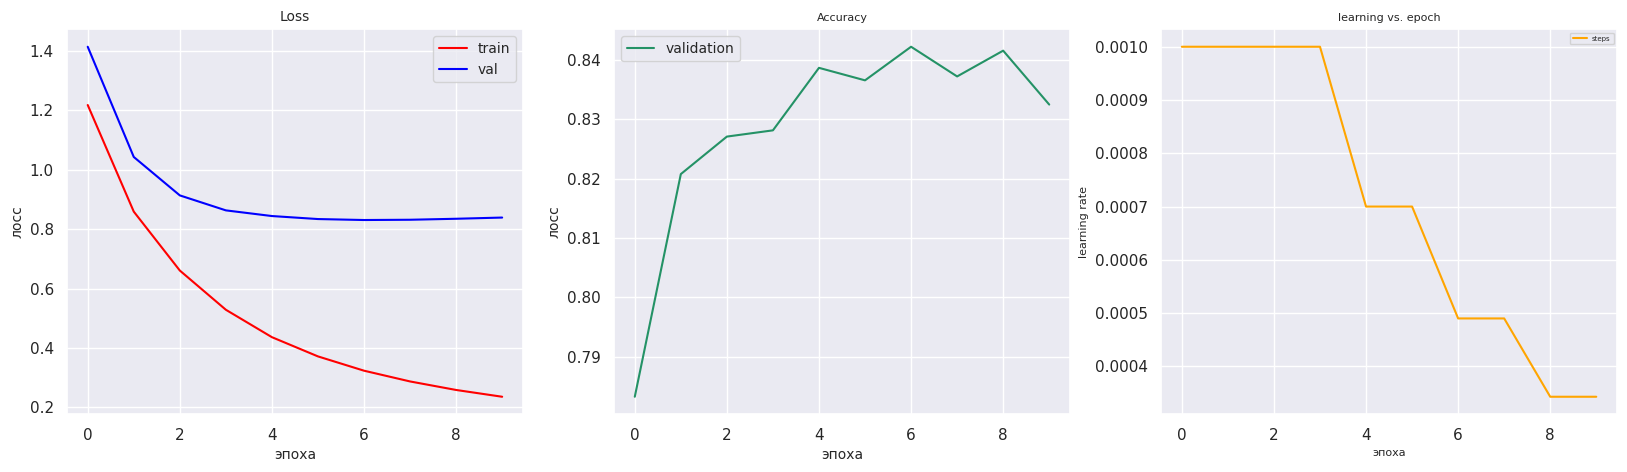

Лучшая accuracy : 84.22


In [46]:
plot_learning(history)

Вывод по графикам:

По графику функции потерь наблюдаем уменьшение ошибки, что хорошо, модель обучается успешно, на валидационной выборке падение ошибки прекращается после
Точность в процессе обучения растет, модель обучается.


### Анализ ошибок модели с лемматизацией

In [57]:
new_model = RNN_Classiff_max(hidden_dim=512, vocab_size=len(vocab), num_classes = 13, num_layers = 2).to(device)
load_model_state = torch.load('best_m7.pt', map_location = device)

new_model.load_state_dict(load_model_state)

<All keys matched successfully>

In [53]:
predictions, target, index =  evaluate_test(new_model, eval_dataloader)

In [54]:
idx, pred, label = [], [], []
pred = [el.item() for el in predictions]
idx = [el.item() for el in index]
label = [el.item() for el in target]
compare_df = pd.DataFrame(columns = ['ind', 'prediction', 'target'])
compare_df = pd.DataFrame({'ind' : idx, 'prediction' : pred, 'target' : label})

In [55]:
# Датасет с ошибочными предсказаниями
error = compare_df.loc[((compare_df['prediction'] != compare_df['target']))]
error['category_true'] = le.inverse_transform(error['target'].values)
error['category_pred'] = le.inverse_transform(error['prediction'].values)

new  = pd.merge(error, df, on="ind", how="inner")
new

,ind,prediction,target,category_true,category_pred,text,label
0,1998,4,1,autosport,esport,‼️Внимание открылась новая шиномонтажная масте...,1
1,33348,4,2,basketball,esport,️Доброго времени суток здесь ты можешь увидеть...,2
2,24190,6,4,esport,football,Успейте оформить кредитную карту от Альфа Банк...,4
3,28280,10,2,basketball,tennis,В телеграмме так же есть активность в будущем ...,2
4,21301,12,11,volleyball,winter_sport,Наши за границей ️ Либеро Татьяна Симанихина ч...,11
...,...,...,...,...,...,...,...
1193,26592,5,11,volleyball,extreme,Добрый вечер 33 Спортивный пляж Казани проводи...,11
1194,2111,8,5,extreme,martial_arts,МАЛЕНЬКИЙ ТЕХНАРЬ Плотная комбинация с идеальн...,5
1195,8018,8,7,hockey,martial_arts,Джейк Генцел набрал сегодня 300 е очко 33 Позд...,7
1196,203,5,11,volleyball,extreme,Серия кресел Legend от бренда KARNOX – это лег...,11


Посмотрим в каких категориях больше всего ошибок

In [58]:
df_new = loads_labels(new.category_true.values)
df_new.reset_index()

,index,category,count
0,5,football,154
1,9,extreme,152
2,4,martial_arts,150
3,2,esport,118
4,10,hockey,105
5,0,autosport,87
6,3,volleyball,83
7,7,winter_sport,80
8,1,basketball,78
9,8,athletics,73


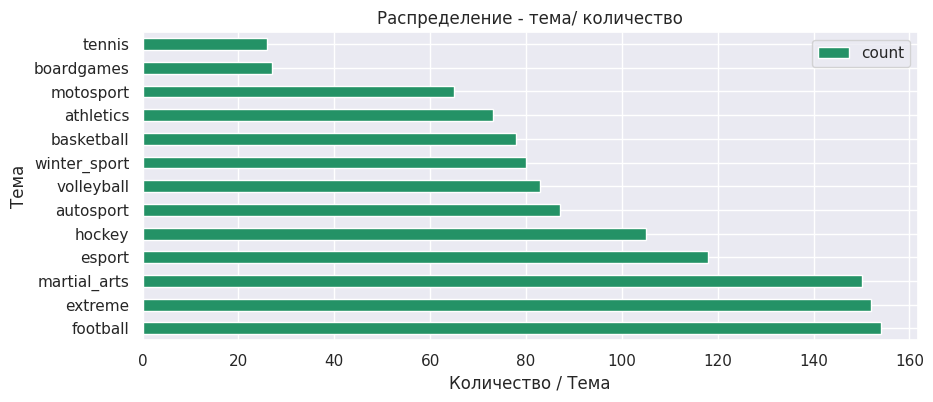

In [59]:
ax = df_new.plot.barh(x='category', y='count', figsize = (10,4), title='Распределение - тема/ количество',
                     xlabel='Количество / Тема',
                     ylabel='Тема')

Количество ошибок уменьшилось, можно еще поработать с текстом, исключить стоп-слова, попробовать мпоменять условия формирования словаря

## Инференс

In [115]:
test = pd.read_csv("test.csv") # загрузка тестового датасета

In [117]:
test_text = test['text'][55]
test_text

'Информационные поводы после ГПМалайзии не исчерпаны 33 Франко Морбиделли получил еще одну пенализацию в Сепанге из за не слишком аккуратной атаки на Алеша Эспаргаро в борьбе за место в ТОП 10. Подробности и вердикт'

In [118]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [119]:
def inference(model, input_text, max_len=256):
    # input_text = " ".join([morph.parse(w)[0].normal_form for w in input_text_.lower().split()])
    processed_txt = input_text.lower().translate(str.maketrans('', '', string.punctuation)) # препроцессинг
    unk_id, bos_id, eos_id, pad_id  = [word2idx[tag] for tag in tags] # тэги
    tok_sent = [word2idx.get(word, unk_id) for word in word_tokenize(processed_txt)] # токенизация
    tok_sent.insert(0, bos_id)
    tok_sent.insert(-1, eos_id)

    max_seq_len = min(len(tok_sent), max_len)
    seq = tok_sent[:max_seq_len]
    for _ in range(max_len - len(tok_sent)):
                seq.append(pad_id)
    seqs = torch.LongTensor(seq)
    seqs = seqs.reshape(1, 256).to(device)

    model.eval()
    logits = model(seqs)
    predictions = logits.argmax(dim=1)
    label = le.inverse_transform([predictions.item()])[0]

    return input_text, label

In [120]:
# вывод результата
sample, category = inference(new_model, 'Волшебные фото Виктория Поплавская ЕвгенияМедведева Evgentokenoid')
print(sample, '\n')
print(category)

Волшебные фото Виктория Поплавская ЕвгенияМедведева Evgentokenoid 

winter_sport


In [121]:
sample, category = inference(new_model, test['text'][55])
print(sample, '\n')
print(category)

Информационные поводы после ГПМалайзии не исчерпаны 33 Франко Морбиделли получил еще одну пенализацию в Сепанге из за не слишком аккуратной атаки на Алеша Эспаргаро в борьбе за место в ТОП 10. Подробности и вердикт 

martial_arts


## Выводы:

Было проведено 2 эксперимента. Обучение на корпусе текста без лемматизации и с лемматизацией. Во втором случае точность модели лучше.  
Точность 1 модели - 82.13 %
Точность 2 модели - 84.5 %
Вторая модель стала значительно меньше ошибаться на категории basketball, и в целом на всех категориях.
